In [21]:
import os
from dotenv import load_dotenv
from tqdm import tqdm
load_dotenv()

from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from tvalmetrics import RagScoresCalculator
from langchain.embeddings import OpenAIEmbeddings
from langchain import FAISS
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from tvalmetrics import RagScoresCalculator
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate


os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
N_TESTS_FOR_QUESTION=10

In [2]:
system_template = """Create an informative and comprehensive answer for a given question based solely on the given documents. You must only use information from the given documents.
Use an unbiased and journalistic tone. Do not repeat text.
Cite the documents using [Document name] notation.
If multiple documents contain the answer, cite those documents like ‘as stated in [Document name 1], [Document name 2], etc.’.
You must include citations in your answer.
If the documents do not contain the answer to the question, say that  ‘answering is not possible given the available information.’
{context}

"""
messages = [
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template("{question}"),
    ]
prompt = ChatPromptTemplate.from_messages(messages)

In [3]:
questions = [
    'How does OAuth facilitate federated authentication in RDAP?',
    'how is command numbering managed in iscsi protocol?',
    'What actions should an SCTP endpoint take when initializing an association?',
    'Does the error response have to be signed by the same key as the original request in TSIG error handling?',
    'Explain to me how to perform secure addition of a new SEP key to a trust point DNSKEY RRSet',
    'What is the difference between very large, but finite delay and packet loss?',
    "What should I do with my TCP implementation if I'm encountering an ICMP Destination Unreachable message with codes 2-4?",
    'What is the difference between ACP point-to-point and multi-access virtual interfaces?',
    'How does the use of DNSSEC impact the interaction between DNS64 and DNS recursive resolvers?',
    'How does YANG support conditional augmentation of data nodes?',
]

reference_answers = [
    "Using OAuth, multiple RDAP servers can form a federation, and the clients can access any server in the same federation by providing one credential registered in any server in that federation.  The OAuth authorization framework is designed for use with HTTP and thus can be used with RDAP.",
   "Command numbering starts with the first Login Request on the first connection of a session (the leading login on the leading connection), and the CmdSN MUST be incremented by 1 in a Serial Number Arithmetic sense, as defined in [RFC1982], for every non-immediate command issued afterwards.", 
    "During the association initialization, an endpoint uses the following rules to discover and collect the destination transport address(es) of its peer. If there are no address parameters present in the received INIT or INIT ACK chunk, the endpoint MUST take the source IP address from which the chunk arrives and record it, in combination with the SCTP Source Port Number, as the only destination transport address for this peer. If there is a Host Name Address parameter present in the received INIT or INIT ACK chunk, the endpoint MUST immediately send an ABORT chunk and MAY include an 'Unresolvable Address' error cause to its peer. The ABORT chunk SHOULD be sent to the source IP address from which the last peer packet was received. If there are only IPv4/IPv6 addresses present in the received INIT or INIT ACK chunk, the receiver MUST derive and record all the transport addresses from the received chunk AND the source IP address that sent the INIT or INIT ACK chunk. The transport addresses are derived by the combination of SCTP Source Port Number (from the common header) and the IP Address parameter(s) carried in the INIT or INIT ACK chunk and the source IP address of the IP datagram. The receiver SHOULD use only these transport addresses as destination transport addresses when sending subsequent packets to its peer. An INIT or INIT ACK chunk MUST be treated as belonging to an already established association (or one in the process of being established) if the use of any of the valid address parameters contained within the chunk would identify an existing TCB.",
    "Yes",
    "Operator adds new SEP key to trust point DNSKey, it is being validated based on the self-signed RRSet. If no other new SEP key is seen in a validated trust points, resolver starts acceptance after proper amount of time expired",
    "Depends on the application, there is a defined range of delay with a specified upper bound (Tmax)",
    "TCP implementations SHOULD abort the connection (SHLD-26)",
    "Implementation of mapping secure channels: point-to-point interfaces create a separate virtual interface for each secure channel, while multi-access interfaces consolidate multiple secure channels into a single virtual interface associated with the underlying subnet",
    "Validating DNS64 resolver increases the confidence on the synthetic AAAA records, as it has validated that a non-synthetic AAAA record doesn't exist. However, if the client device is oblivious to NAT64 (the most common case) and performs DNSSEC validation on the AAAA record, it will fail as it is a synthesized record.",
    "conditional augmentation of data nodes is supported through the use of the 'augment' statement in combination with the 'when' statement. The 'augment' statement allows you to add or extend data nodes in an existing data tree, and the 'when' statement provides a condition under which the augmentation takes effect."
]


In [7]:
llm = OpenAI(openai_api_key=os.getenv('OPENAI_API_KEY'))
faiss_local_path = '../data/embedded_dataset/faiss/openai_1500/faiss_idx'
embeddings = OpenAIEmbeddings(openai_api_key=os.getenv('OPENAI_API_KEY'))
db = FAISS.load_local(faiss_local_path, embeddings)

In [8]:
answers = []
retrieved_contexts = []
for idx in range(len(questions)):
    conversation_chain = ConversationalRetrievalChain.from_llm(
            llm,
            db.as_retriever(search_kwargs={"k": 3}),
            memory=ConversationBufferMemory(
            memory_key="chat_history", return_messages=True, output_key="answer"
        ),
            return_source_documents=True,
            combine_docs_chain_kwargs={
                "document_prompt": PromptTemplate(
                    input_variables=["page_content", "Source"],
                    template="Document name: {Source}\nContext:\n{page_content}",
                ),
                "prompt": prompt,
            },
        )
    
    response = conversation_chain(questions[idx])
    answers.append(response['answer'])
    retrieved_contexts.append(response['source_documents'])

In [9]:
llm_evaluator = "gpt-4"
score_calculator = RagScoresCalculator(
    model=llm_evaluator,
    answer_similarity_score=True,
    retrieval_precision=True,
    augmentation_precision=True,
    augmentation_accuracy=True,
    answer_consistency=True,
)

In [10]:
scores = score_calculator.score_batch(
    questions,
    reference_answers,
    answers,
    retrieved_contexts
)

In [12]:
scored_df = scores.to_dataframe()

In [42]:
renamed_df= scored_df.rename(columns={
    'question': 'Question',
    'reference_answer': 'Reference answer',
    'llm_answer': 'LLM answer',
    'retrieved_context': 'Retrieved context',
    'answer_similarity_score': 'Answer similarity score',
    'retrieval_precision': 'Retrieval precision',
    'augmentation_precision': 'Augmentation precision',
    'augmentation_accuracy': 'Augmentation accuracy',
    'answer_consistency': 'Answer consistency',
    'overall_score': 'Overall score',
})
    

In [43]:
renamed_df

,Question,Reference answer,LLM answer,Retrieved context,Answer similarity score,Retrieval precision,Augmentation precision,Augmentation accuracy,Answer consistency,Overall score
0,How does OAuth facilitate federated authentica...,"Using OAuth, multiple RDAP servers can form a ...",\n\nOAuth is used to provide federated authent...,"[page_content=""Federated authentication mechan...",5.0,0.666667,0.500000,0.333333,1.000000,0.700000
1,how is command numbering managed in iscsi prot...,Command numbering starts with the first Login ...,"\n\nIn the iSCSI protocol, Command numbering i...",[page_content='The iSCSI session abstraction i...,5.0,1.000000,1.000000,1.000000,1.000000,1.000000
2,What actions should an SCTP endpoint take when...,"During the association initialization, an endp...",\n\nAn SCTP endpoint should use the ASSOCIATE ...,[page_content='1.5.1. Association Startup and ...,2.0,1.000000,0.666667,0.666667,1.000000,0.746667
3,Does the error response have to be signed by t...,Yes,\n\nAnswering is not possible given the availa...,[page_content='4.2. TSIG on Answers\n\n When...,0.0,0.666667,0.000000,0.000000,0.000000,0.133333
4,Explain to me how to perform secure addition o...,Operator adds new SEP key to trust point DNSKe...,. \n\nAdding a new Secure Entry Point (SEP) ke...,"[page_content=""6. Scenarios - Informative\n\n...",4.0,1.000000,1.000000,1.000000,1.000000,0.960000
5,"What is the difference between very large, but...","Depends on the application, there is a defined...","\n\nThe difference between very large, but fin...",[page_content='5.4.1. Packet Loss Detection\n...,4.0,1.000000,0.666667,0.666667,1.000000,0.826667
6,What should I do with my TCP implementation if...,TCP implementations SHOULD abort the connectio...,"\n\nBased on the information provided in ""Requ...","[page_content='It is not obvious, when error m...",5.0,1.000000,0.333333,0.333333,0.800000,0.693333
7,What is the difference between ACP point-to-po...,Implementation of mapping secure channels: poi...,"\n\nAnswer: According to [Document name 1], po...",[page_content='6.13.5.2.2. ACP Multi-Access Vi...,1.0,0.000000,0.000000,0.333333,1.000000,0.306667
8,How does the use of DNSSEC impact the interact...,Validating DNS64 resolver increases the confid...,\n\nDNSSEC is designed to detect modifications...,[page_content='As indicated in the security co...,4.0,1.000000,1.000000,1.000000,0.833333,0.926667
9,How does YANG support conditional augmentation...,conditional augmentation of data nodes is supp...,\n\nYANG supports conditional augmentation of ...,[page_content='4.19.1. Conditional Augment St...,5.0,0.666667,1.000000,0.666667,1.000000,0.866667


In [17]:
import numpy as np
numeric_columns = scored_df.select_dtypes(include=[np.number]).columns
test_df = scored_df.groupby(np.arange(len(scored_df)) // 2)[numeric_columns].mean()

In [18]:
test_df

,answer_similarity_score,retrieval_precision,augmentation_precision,augmentation_accuracy,answer_consistency,overall_score
0,5.0,0.833333,0.750000,0.666667,1.000000,0.850000
1,1.0,0.833333,0.333333,0.333333,0.500000,0.440000
2,4.0,1.000000,0.833333,0.833333,1.000000,0.893333
3,3.0,0.500000,0.166667,0.333333,0.900000,0.500000
4,4.5,0.833333,1.000000,0.833333,0.916667,0.896667


In [45]:
result_df = pd.concat([renamed_df['Question'], test_df[['answer_similarity_score', 'retrieval_precision', 'augmentation_precision', 'augmentation_accuracy',
                                                   'answer_consistency',
                                                  'overall_score']]], axis=1)

In [46]:
result_df

,Question,answer_similarity_score,retrieval_precision,augmentation_precision,augmentation_accuracy,answer_consistency,overall_score
0,How does OAuth facilitate federated authentica...,5.0,0.833333,0.750000,0.666667,1.000000,0.850000
1,how is command numbering managed in iscsi prot...,1.0,0.833333,0.333333,0.333333,0.500000,0.440000
2,What actions should an SCTP endpoint take when...,4.0,1.000000,0.833333,0.833333,1.000000,0.893333
3,Does the error response have to be signed by t...,3.0,0.500000,0.166667,0.333333,0.900000,0.500000
4,Explain to me how to perform secure addition o...,4.5,0.833333,1.000000,0.833333,0.916667,0.896667
5,"What is the difference between very large, but...",NaN,NaN,NaN,NaN,NaN,NaN
6,What should I do with my TCP implementation if...,NaN,NaN,NaN,NaN,NaN,NaN
7,What is the difference between ACP point-to-po...,NaN,NaN,NaN,NaN,NaN,NaN
8,How does the use of DNSSEC impact the interact...,NaN,NaN,NaN,NaN,NaN,NaN
9,How does YANG support conditional augmentation...,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

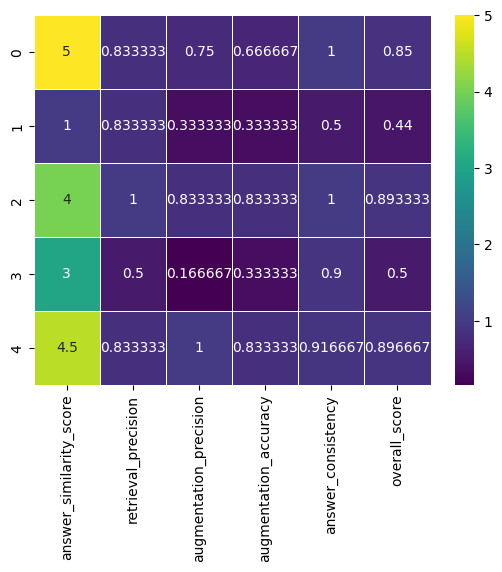

In [37]:
import seaborn as sns
sns.heatmap(test_df, annot=True, cmap='viridis', linewidths=.5, fmt='g')

In [38]:
scored_df.to_json('test.json', orient='records')

In [40]:
import pandas as pd
loaded_scored_df = pd.read_json('test.json', orient='records')